# Testing Zero Shot Super Resolution (ZSSR)



In [1]:
!pip install pyhdf h5py pytorch-ignite PyWavelets piqa -q

import PIL
import numpy as np
import sys
import json
import itertools
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.functional import interpolate
from torchvision import transforms
from torchvision.transforms import functional as ttf
import numbers
import cv2
from tqdm import tqdm
from pyhdf.SD import SD, SDC
from h5py import File as h5File
import pywt as pywt

from einops import rearrange
import matplotlib.pyplot as plt

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.metrics.regression import *
from ignite.utils import *

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


### Utilities loading

In [2]:
class TensorRandomRotationFromSequence(object):
    def __init__(self, degree):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        angle = np.random.choice(degrees)
        return angle
    def __call__(self, collapsed):
        angle = self.get_params(self.degrees)
        return ttf.rotate(collapsed, angle)

class RandomRotationFromSequence(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
    """

    def __init__(self, degrees):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.choice(degrees)
        return angle

    def __call__(self, data):
        """img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        angle = self.get_params(self.degrees)
        try: # as in original implementation
            hr, lr = data
            return ttf.rotate(hr, angle), ttf.rotate(lr, angle)
        except: # if you are providing a tensor
            return ttf.rotate(data, angle)

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.hflip(hr), ttf.hflip(lr)
        return hr, lr

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.vflip(hr), ttf.vflip(lr)
        return hr, lr

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(data, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        hr, lr = data
        _, _,h, w = hr.shape
        th, tw = output_size
        if w == tw or h == th:
            return 0, 0, h, w

        if w < tw or h < th:
            th, tw = h//2, w//2

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        try:
            hr, lr = data
        except:
            hr = data[0, :,:,:].unsqueeze(0)
            lr = data[1, :,:,:].unsqueeze(0)

        if self.padding > 0:
            hr = ttf.pad(hr, self.padding)
            lr = ttf.pad(lr, self.padding)

        i, j, h, w = self.get_params(data, self.size)
        return ttf.crop(hr, i, j, h, w), ttf.crop(lr, i, j, h, w)

class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, data):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        hr, lr = data
        return ttf.to_tensor(hr), ttf.to_tensor(lr)


def read_h5_temperature(filename):
    """ Return torch tensor"""
    #Open the H5 file in read mode
    with h5File(filename, 'r') as f:
        tmp = torch.Tensor(f["Temperature"]["Mean"]).unsqueeze(0)
        tmp = torch.where(tmp==-9999, tmp[tmp!=0].mean(), tmp)
        tmp = tmp * 0.01
        tmp = tmp / tmp.max()
        return tmp

def rescale_data(lr, hr):
    max_val = max(lr.max().item(), hr.max().item())
    return lr / max_val, hr / max_val

# General Utils
def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

### Evaluation metrics


In [3]:
from piqa import SSIM

class SSIMLoss(SSIM):
    @staticmethod
    def check_dim(x):
        _, c, _, _ = x.shape
        if c == 1:
            x = x.repeat(1,3,1,1)
        elif c == 2:
            x = x[:,0,:,:].unsqueeze(1).repeat(1,3,1,1)
        return x

    @staticmethod
    def cast_values(x):
        x = torch.where(x<0, 0.0, x)
        x = torch.where(x>1, 1.0, x)
        return x

    def forward(self, x, y):
        x = self.check_dim(self.cast_values(x))
        y = self.check_dim(self.cast_values(y))
        return 1. - super().forward(x, y)

class PSNR(nn.Module):
    def __init__(self):
        super(PSNR, self).__init__()
        self.name = "PSNR"
    def forward(self, x, y):
        mse = torch.mean((x - y) ** 2)
        return -(20 * torch.log10(1.0 / torch.sqrt(mse)))

ssim = SSIMLoss()
x = torch.rand((1,1,64,64))
print(ssim(x,x))

tensor(0.)


### Architectures loading

#### ZSSRnet
Reference

```Adapted From: https://github.com/jacobgil/pytorch-zssr (Apache License)  @ jacobgil ```


In [4]:
import torch
import torch.nn as nn

class ZSSRNet(nn.Module):
    def __init__(self, input_channels=1, out_channels=1, kernel_size=3, channels=64, ndepth=6):
        super(ZSSRNet, self).__init__()

        internalblocks = [nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same", bias=True),
            nn.ReLU())
            for _ in range(ndepth)
        ]

        self.conv_i = nn.Sequential(
            nn.Conv2d(input_channels, channels, kernel_size, padding="same", bias=True),
            nn.ReLU())
        self.conv_m = nn.Sequential(*internalblocks)
        self.conv_f = nn.Conv2d(channels, out_channels, kernel_size, padding="same", bias=True)

    def forward(self, x):
        orig = x[:,0,:,:].unsqueeze(1).clone()
        x = self.conv_i(x)
        x = self.conv_m(x)
        x = self.conv_f(x)
        return x + orig

#### MRUNet
Reference
```
Adapted from: https://github.com/IMT-Project-LTS-SR/MRUNet-for-MODIS-super-resolution/blob/main/model.py
```

In [5]:
import torch
import cv2
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torchvision.utils import save_image
from torchvision import transforms
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import os
import torch.nn.functional as F

from math import sqrt

import torch.nn.init as init

num = 64
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_Down(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv_Down, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, res_down=False):
        super(Down, self).__init__()
        self.res_down = res_down
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        if self.res_down:
            self.in_conv = nn.Conv2d(in_channels, in_channels, kernel_size=2, stride=2)
            self.mid_conv = DoubleConv(in_channels, in_channels)
            self.out_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.res_down:
            return self.out_conv(self.mid_conv((self.in_conv(x))) + self.in_conv(x))
        else:
            return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2],mode='reflect')
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.conv = nn.Sequential(
        #     nn.Conv2d(in_channels, out_channels, kernel_size=1),
        #     nn.Sigmoid())

    def forward(self, x):
        return self.conv(x)

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

class MRUNet(nn.Module):
    def __init__(self, n_channels=1, n_outchannels=1, res_down=False, n_resblocks=1,
                 padding_type="reflect", norm_layer=nn.BatchNorm2d, use_dropout=False,
                 use_bias=True, bilinear=False):
        super(MRUNet, self).__init__()
        self.n_channels = n_channels
        self.n_outchannels = n_outchannels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)

        ### Encoder
        factor = 2 if bilinear else 1

        self.down1 = Down(64, 128, res_down=res_down)
        self.down2 = Down(128, 256, res_down=res_down)
        self.down3 = Down(256, 512, res_down=res_down)
        self.down4 = Down(512, 1024 // factor, res_down=res_down)

        ### Residual blocks
        resblocks = []
        for i in range(n_resblocks):
            resblocks += [ResnetBlock(1024 // factor, padding_type, norm_layer, use_dropout, use_bias)]
        self.resblocks = nn.Sequential(*resblocks)

        ### Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_outchannels)
        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.up_dc = DoubleConv(64, 64)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x):
        orig = x[:, 0, :, :].unsqueeze(1)
        x1 = self.inc(x) #64
        x2 = self.down1(x1) #128
        x3 = self.down2(x2) #256
        x4 = self.down3(x3) #512
        x5 = self.down4(x4) #1024

        x5 = self.resblocks(x5)

        xp1 = self.up1(x5, x4) #512
        xp2 = self.up2(xp1, x3) #256
        xp3 = self.up3(xp2, x2) #128
        xp4 = self.up4(xp3, x1) #64
        # x = self.up(x)
        # x = self.up_dc(x)
        out = self.outc(xp4) + orig
        return out

# Sampler Implementation

### DataSampler, tensor implementation
Deprecated

In [12]:
class DataSamplerSingle:
    def __init__(self, img, sr_factor, crop_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        self.crop_size = crop_size

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True) ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))

        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            pair = torch.cat([hr, lr], 0)
            pair = self.transform(pair)
            pair = self.rotate(pair)
            pair = self.force_patch_size(pair)
            hr_tensor = pair[0, :, :, :].unsqueeze(0)
            lr_tensor = pair[1, :, :, :].unsqueeze(0)
            yield hr_tensor, lr_tensor


torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


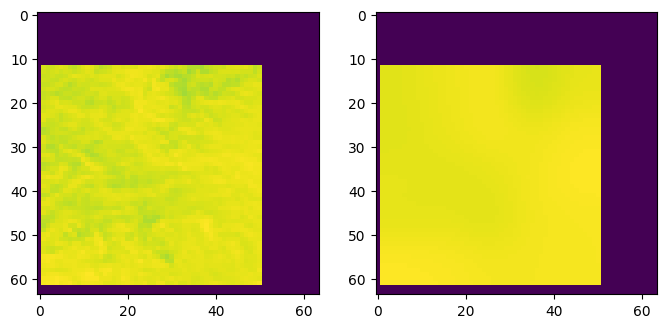

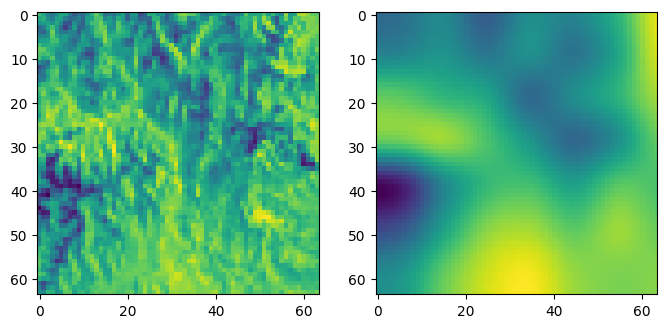

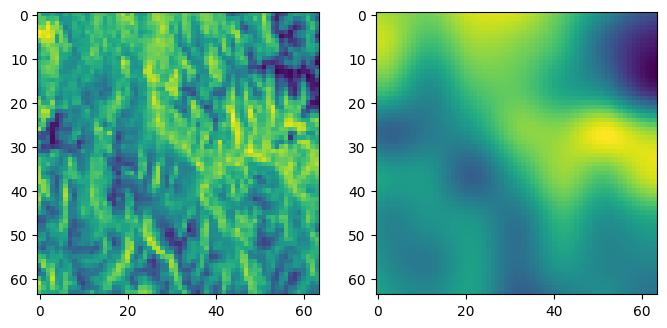

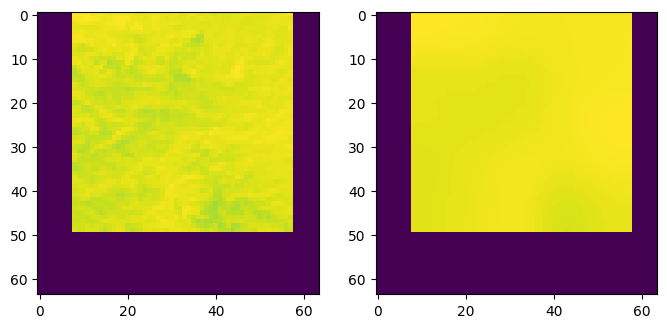

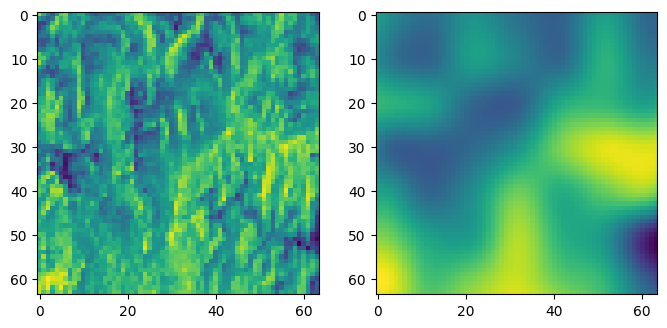

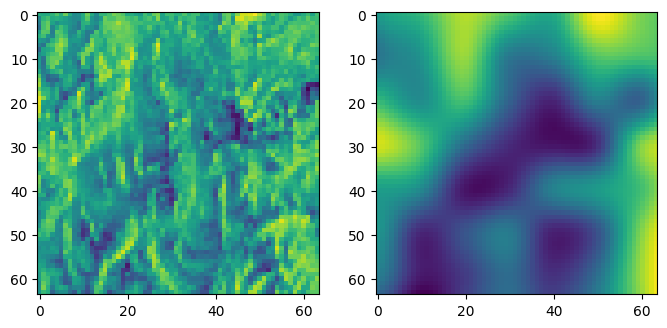

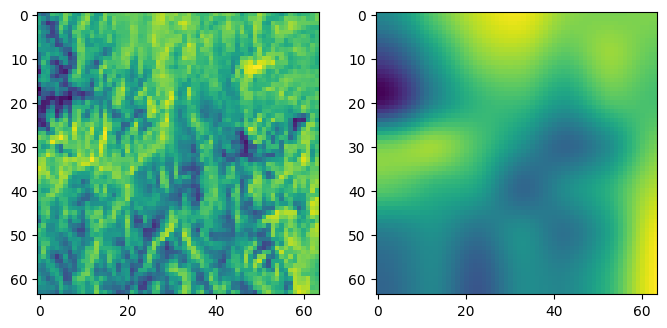

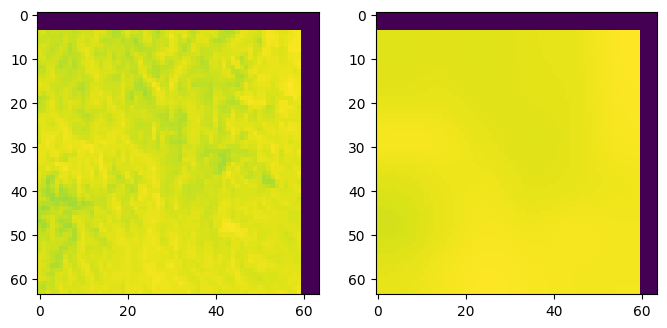

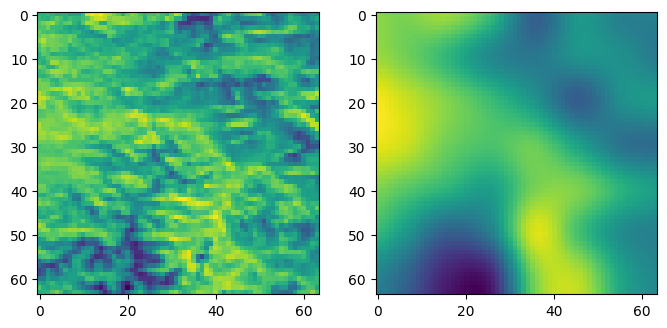

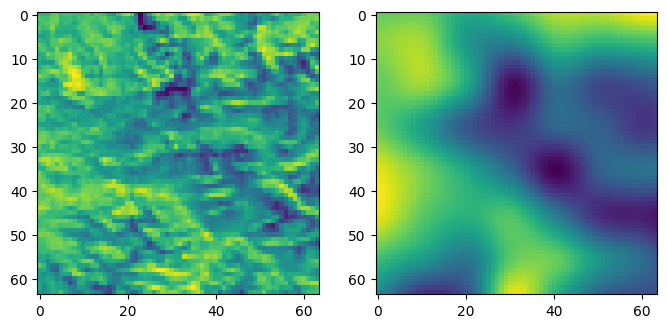

In [13]:
filenameLR = "AG1km.v003.45.006.0010.h5"
filenameHR = "AG100.v003.45.006.0001.h5"
img = read_h5_temperature(filenameLR)

sampler = DataSamplerSingle(img, sr_factor=10, crop_size=64)

c = 0
while c<10:
    hr, lr = sampler.generate_data().__next__()
    print(hr.shape, lr.shape)
    _,axs = plt.subplots(1, 2, figsize=(8,5))
    axs[0].imshow((hr.squeeze()))
    axs[1].imshow((lr.squeeze()))
    c+=1

Showing intermediate scale factor degradation.

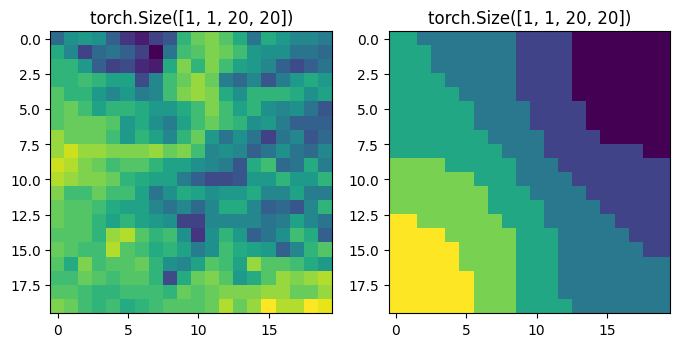

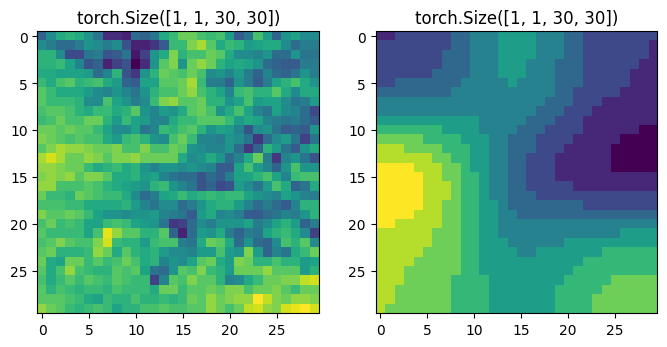

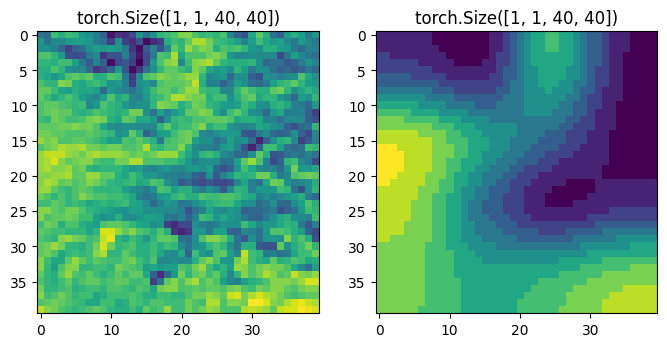

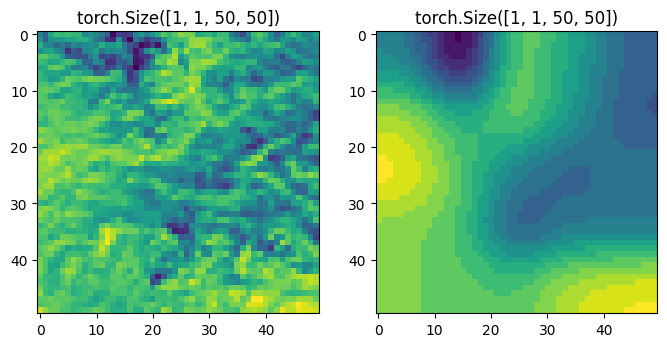

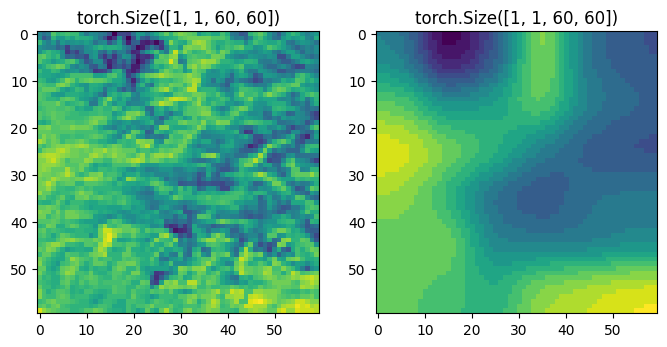

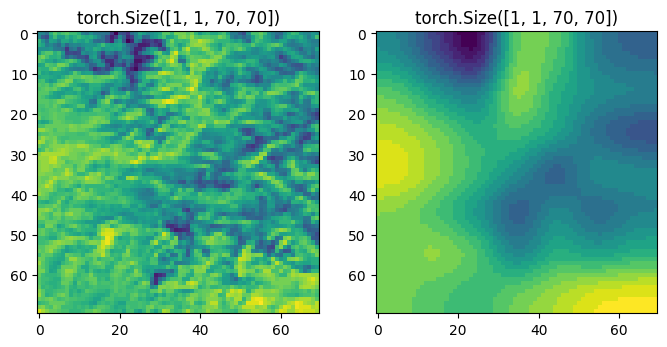

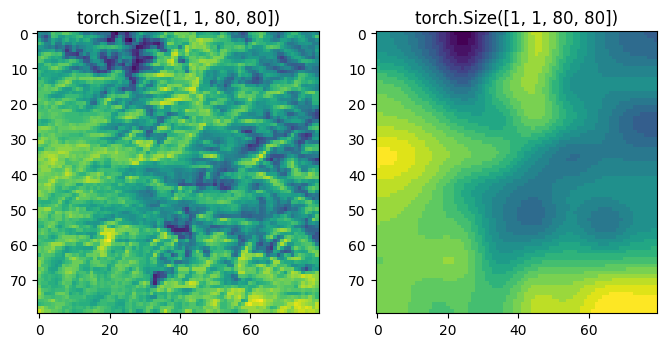

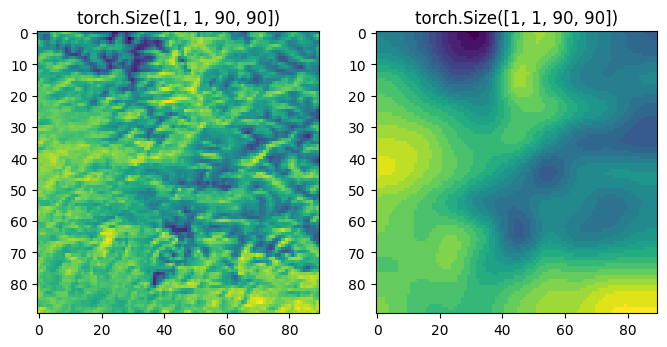

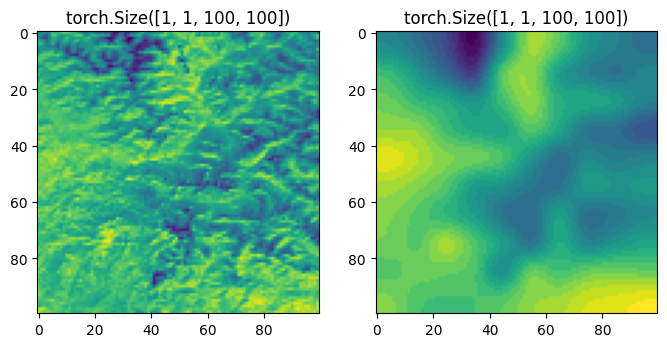

In [14]:
for hr, lr in sampler.pairs:
    _, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(ttf.to_pil_image(hr.squeeze())); axs[0].set_title(hr.shape)
    axs[1].imshow(ttf.to_pil_image(lr.squeeze())); axs[1].set_title(lr.shape)
    plt.show()

### DataSampler, Batch implementation

The present implementation enables to yield batches of samples that undergo augmentation via default

Deprecated


In [15]:
class DataSamplerBatch:
    def __init__(self, img, sr_factor, crop_size, batch_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.pairs = self.create_hr_lr_pairs()

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True)
             ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        self.factors, pairs = [], []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)
        for zoom in self.factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))
        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = [] # or torch .zeros
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair)
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor

### DataSampler, Batch implementation, High Frequency
Deprecated


In [16]:
class DataSamplerBatchHF():
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=True):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.hfimg = self.get_hf_components(self.img)
        self.img = torch.cat([self.img, self.hfimg], 1)

        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.crop_only = crop_only

        self.pairs = self.create_hr_lr_pairs()


        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        if self.crop_only:
            self.transform = transforms.Compose([
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])

        self.degrees = [0., 90., 180., 270.]

    @staticmethod
    def get_hf_components(x):
        """ Args:
            x: (torch.Tensor) of dim (_, _, h, w)
        """
        _, c, h, w = x.shape
        x = F.interpolate(x, scale_factor=2, mode="bicubic", antialias=True)
        _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1])

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        self.factors, pairs = [], []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)
        for zoom in self.factors:
            hr = F.interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            hr_only = hr[:, 0, :, :].unsqueeze(0)
            hfmap   = hr[:, 1, :, :].unsqueeze(0)
            lr = F.interpolate(hr_only, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = F.interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            lr = torch.cat([lr, hfmap], 1)
            pairs.append((hr, lr))
        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = F.interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = []
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair) if not self.crop_only else pair
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor

batch_size = 8
crop_size  = 64
sr_factor  = 10

filenameLR = "AG1km.v003.45.006.0010.h5"
filenameHR = "AG100.v003.45.006.0001.h5"
img = read_h5_temperature(filenameLR)

sampler = DataSamplerBatchHF(img, sr_factor, crop_size, batch_size, crop_only=False)

In [ ]:
n = 16
crop_size=24
transform = transforms.Compose([transforms.RandomCrop((crop_size, crop_size),
                                       pad_if_needed=True)])
pair = sampler.pairs[0]
hr, lr = pair
pair = torch.cat([hr, lr], 0).unsqueeze(0).repeat(n,1,1,1,1)
batch = []
for i in range(n):
    curr_pair = pair[i, :, :, :, :]
    curr_pair = transform(curr_pair).unsqueeze(0)
    batch.append(curr_pair)
batch = torch.cat(batch, 0)

hr_tensor = batch[:, 0, :, :, :]
lr_tensor = batch[:, 1, :, :, :]
hr_tensor.shape

### Optimised implementation

In [17]:
class DataSampler(object):
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=False):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w).to(DEVICE)
        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.crop_only  = crop_only
        self.factors = []
        self.pairs = []
        self.create_intermediate_factors()

        if self.crop_only:
            self.transform = transforms.Compose([
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        self.degrees = [0., 90., 180., 270.]

    def create_intermediate_factors(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side * zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return a random choosen batch of sampled data """
        while True:
            # List of pairs
            batch = []
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair) if not self.crop_only else pair
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor


class DataSamplerBatch(DataSampler):

    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=True):
        super().__init__(img, sr_factor, crop_size, batch_size, crop_only)

        # generate intermediate scale factors pairs
        self.create_hr_lr_pairs()
        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

    def create_hr_lr_pairs(self):
        self.pairs = []
        for zoom in self.factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            self.pairs.append((hr, lr))


class DataSamplerBatchHF(DataSampler):
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=True):
        super().__init__(img, sr_factor, crop_size, batch_size, crop_only)

        # Appending HF components at channel dimension
        self.hfimg = self.get_hf_components(self.img).to(DEVICE)
        self.img = torch.cat([self.img, self.hfimg], 1).to(DEVICE)

        # generate intermediate scale factors pairs
        self.create_hr_lr_pairs()
        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

    @staticmethod
    def get_hf_components(x):
        """ Args: x: (torch.Tensor) of dim (_, _, h, w)
        """
        tmp = x.clone()
        _, _, h, w = x.shape
        x = F.interpolate(tmp.detach().cpu(), scale_factor=2, mode="bicubic", antialias=True)
        _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1])

    def create_hr_lr_pairs(self):
        self.pairs = []
        for zoom in self.factors:
            hr = F.interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            hr_only = hr[:, 0, :, :].unsqueeze(0)
            hfmap   = hr[:, 1, :, :].unsqueeze(0)
            lr = F.interpolate(hr_only, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = F.interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            lr = torch.cat([lr, hfmap], 1)
            self.pairs.append((hr, lr))


### Intermediate SF dataset
Adapting a customised Dataset object that draws augmentation over intermediate scaled LR images.

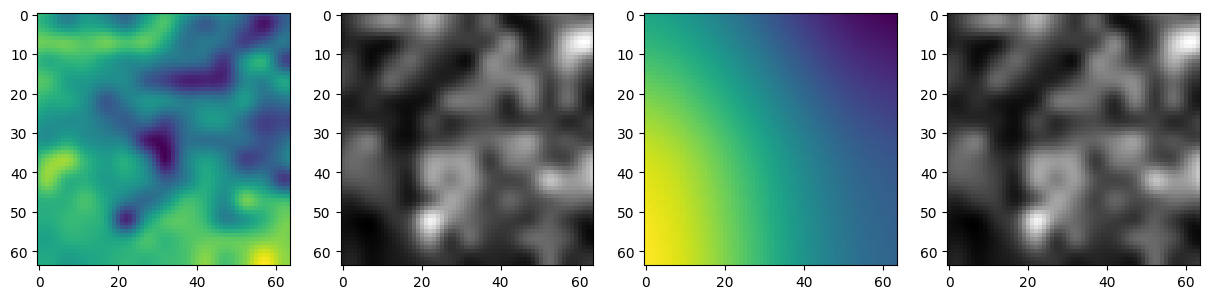

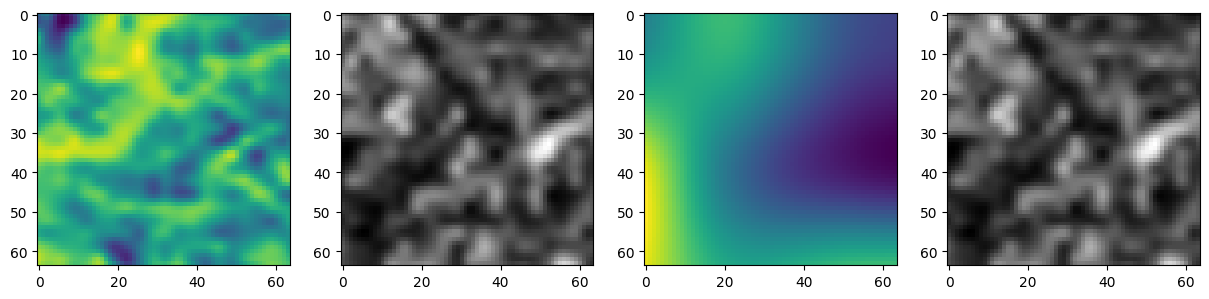

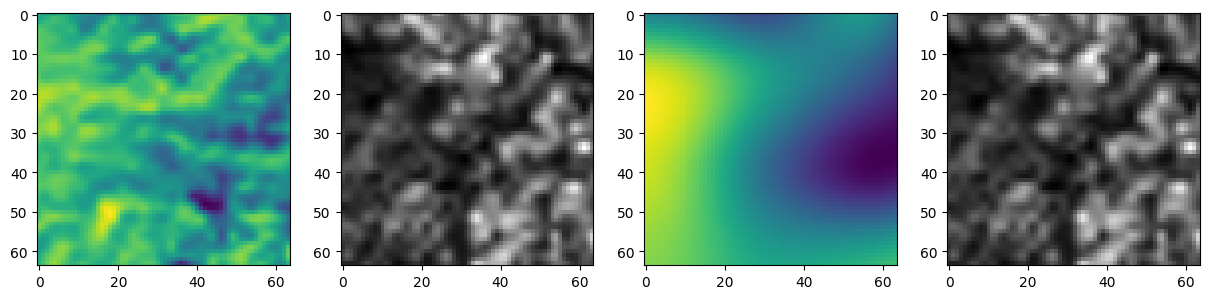

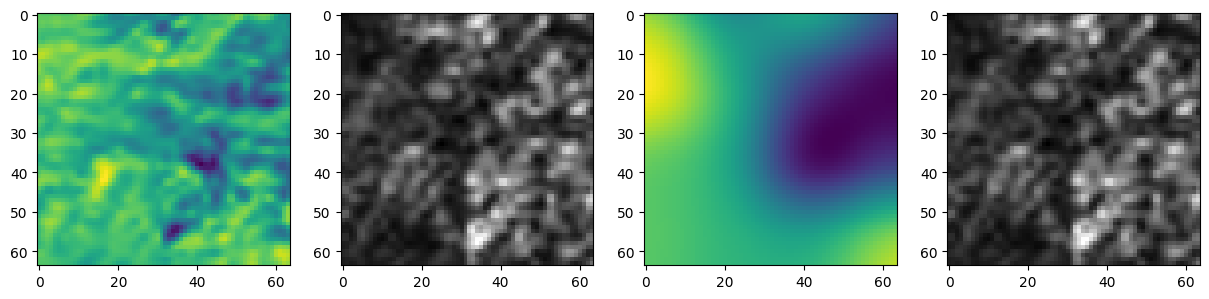

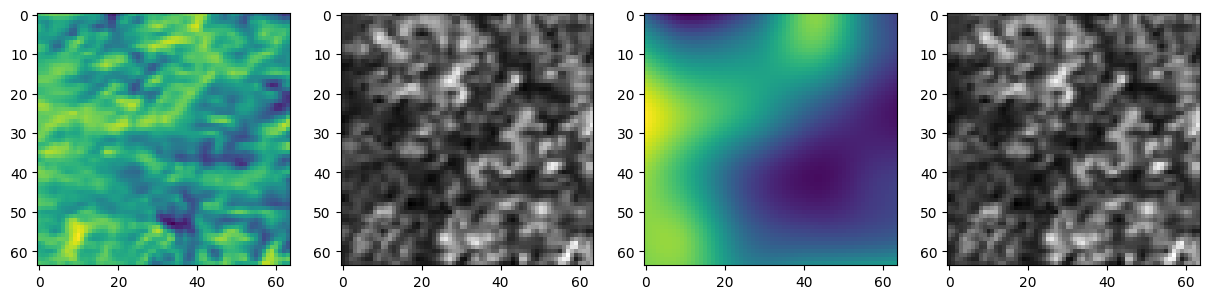

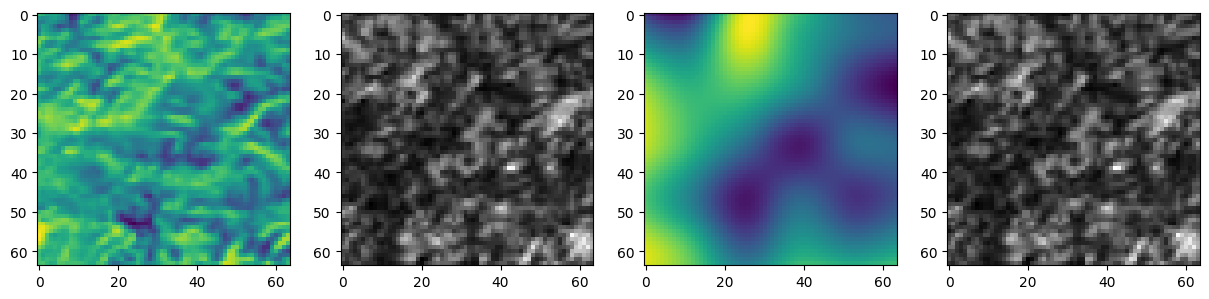

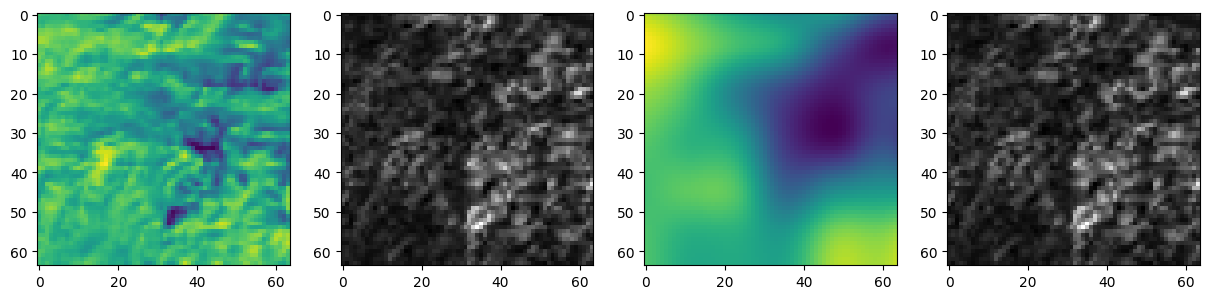

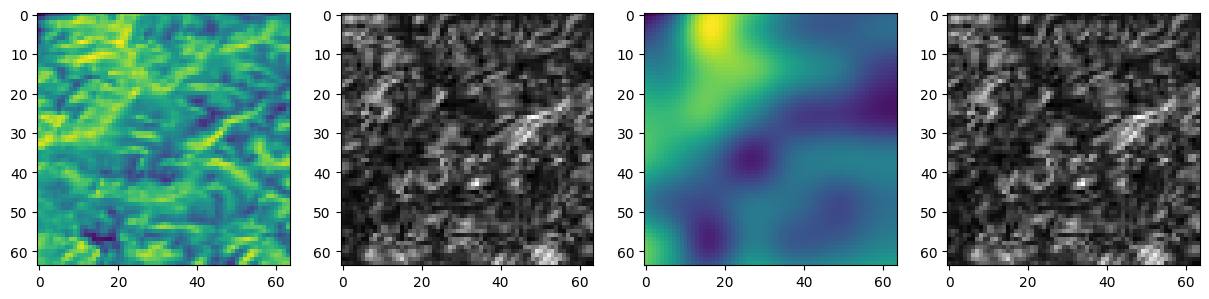

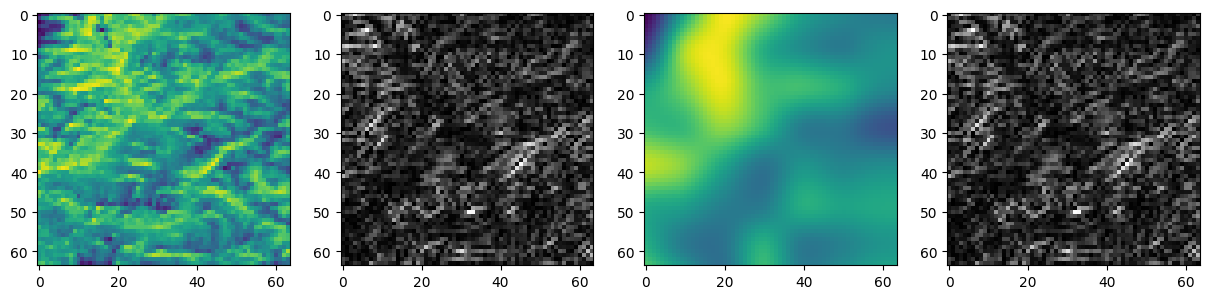

In [18]:
class IntermediateDataset(Dataset):
    def __init__(self, n, pair, full_size, transform):
        """ Args:
            n: (int) amount of child degradated images to be drawn from the curr pair
            pair: (tuple) of hr, lr tensors
        """
        self.n = n
        self.pair = pair
        self.hr, self.lr = self.pair
        _, self.c, _, _ = self.hr.shape
        self.full_size = full_size
        self.transform = transform

        # Initialise empty dataset to be scanned
        self.hr_tensor, self.lr_tensor = self.draw_subset()
        self.hr_tensor = self.hr_tensor.to(DEVICE)
        self.lr_tensor = self.lr_tensor.to(DEVICE)

    @staticmethod
    def force_patch_size(tensor, outdim):
        _, _, h, w = tensor.shape
        return interpolate(tensor, size=(outdim, outdim), mode="bicubic",
                 antialias=True) if (h, w) != (outdim, outdim) else tensor

    def draw_subset(self):
        # from tuple to tensor of dim (n, 2, c, h, w)
        batch = []
        pair = torch.cat([self.hr, self.lr], 0).unsqueeze(0).repeat(self.n, 1, 1, 1, 1)

        for i in range(self.n):
            curr_pair = pair[i, :, :, :, :]       # now on dim (2, c, h, w)
            curr_pair = self.force_patch_size(curr_pair, self.full_size)
            curr_pair = self.transform(curr_pair) # now on dim (2, c, h, w)
            batch.append(curr_pair.unsqueeze(0))  # now on dim (1, 2, c, h, w)
        batch = torch.cat(batch, 0)

        hr_tensor = batch[:, 0, :, :, :] # to dim (n, c, h, w)
        lr_tensor = batch[:, 1, :, :, :] # to dim (n, c, h, w)
        return hr_tensor, lr_tensor

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.hr_tensor[idx,:,:,:], self.lr_tensor[idx,:,:,:]

# test
full_size  = 100
crop_size  = 64
batch_size = 1
filenameLR = "AG1km.v003.45.006.0010.h5"
filenameHR = "AG100.v003.45.006.0001.h5"
img = read_h5_temperature(filenameLR)
transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size), pad_if_needed=True)])
sampler = DataSamplerBatchHF(img, sr_factor=10, crop_size=crop_size, batch_size=batch_size, crop_only=False)

for j in range(0, len(sampler.pairs)):
    ids = IntermediateDataset(20, sampler.pairs[j], full_size, transf)
    dl  = torch.utils.data.DataLoader(ids, batch_size=batch_size, shuffle=False)
    hr, lr = iter(dl).__next__()
    for i in range(batch_size):
        _,axs = plt.subplots(1, 4, figsize=(15,8))
        axs[0].imshow(hr[i, 0, :, :].detach().cpu().squeeze())
        axs[1].imshow(hr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")
        axs[2].imshow(lr[i, 0, :, :].detach().cpu().squeeze())
        axs[3].imshow(lr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")

Displaying intermediate factor pairs.

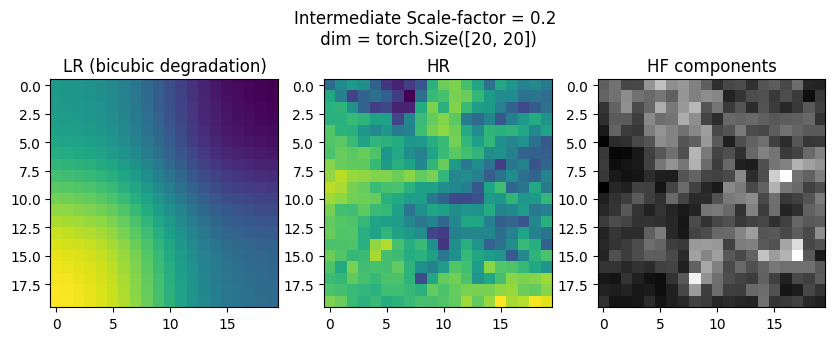

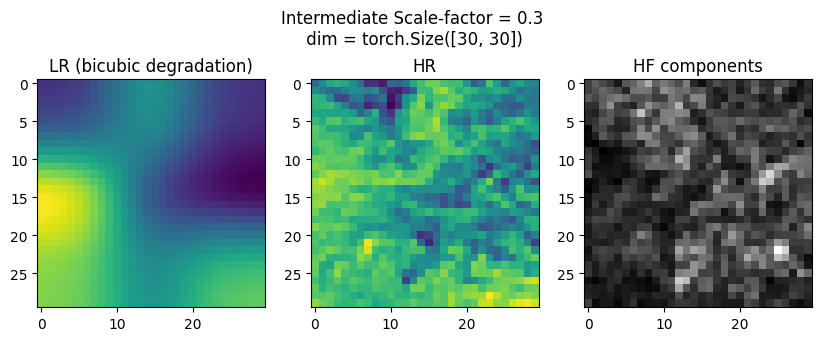

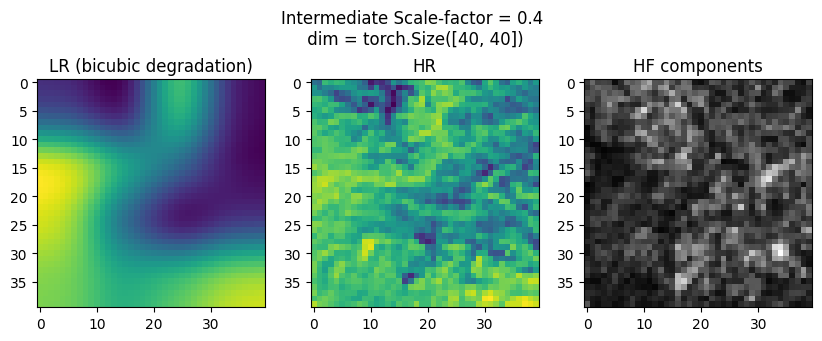

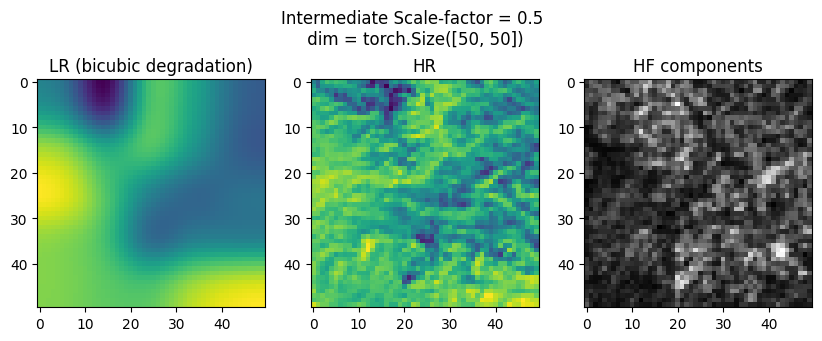

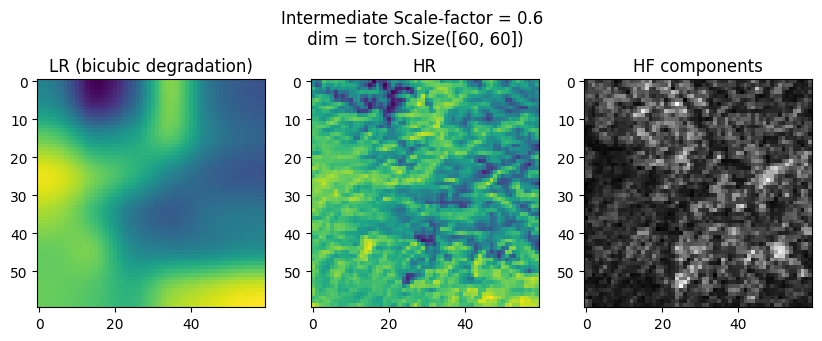

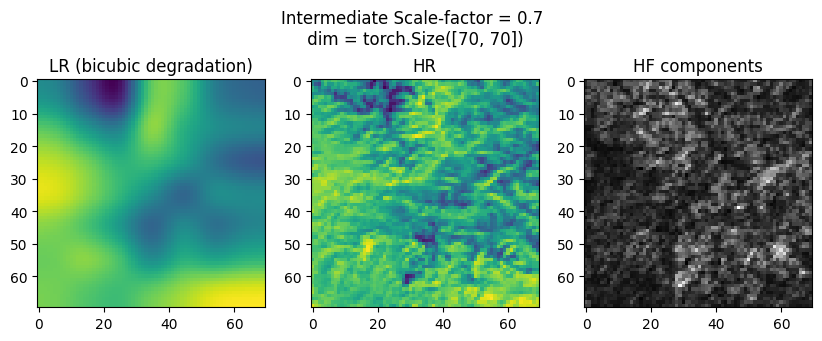

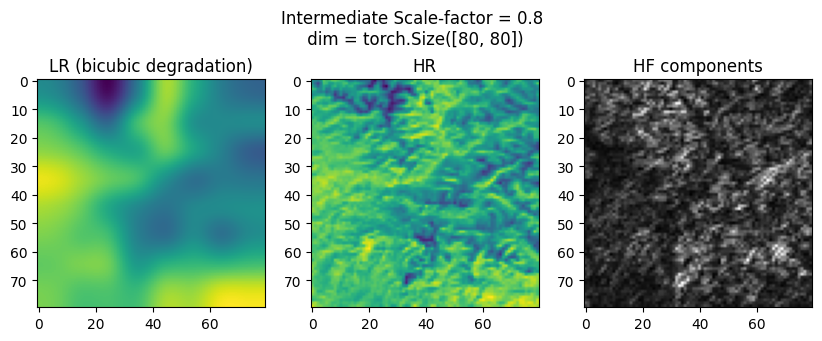

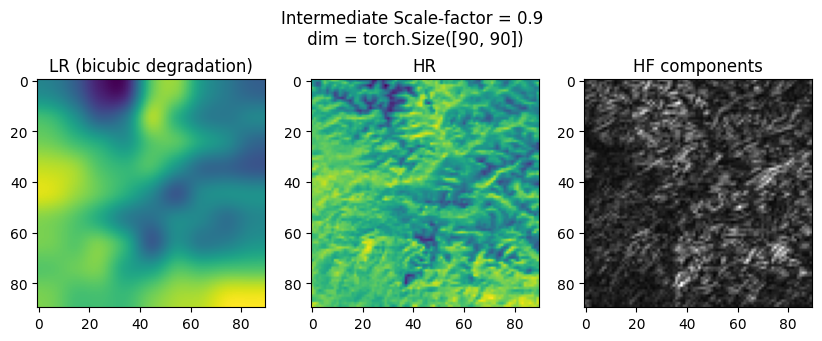

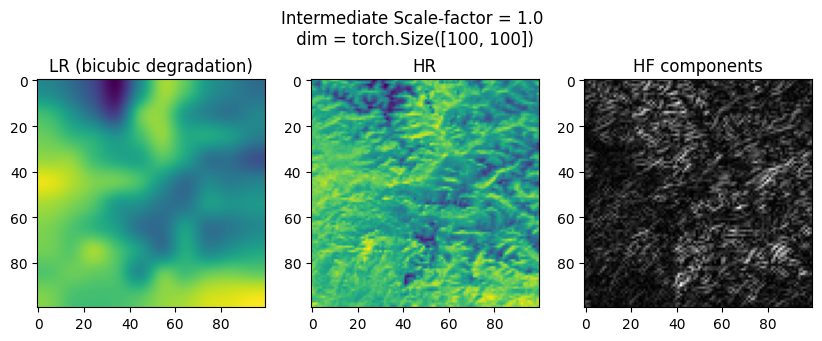

In [19]:
for i, (hr, lr) in enumerate(sampler.pairs):
    _, axs = plt.subplots(1, 3, figsize=(10,3.8))
    l, h, hf = lr[:, 0, :, :].squeeze(), hr[:, 0, :, :].squeeze(), hr[:, 1, :, :].squeeze()
    axs[0].imshow(l.detach().cpu()); axs[0].set_title(f"LR (bicubic degradation)")
    axs[1].imshow(h.detach().cpu()); axs[1].set_title(f"HR")
    axs[2].imshow(hf.detach().cpu(), cmap="gray"); axs[2].set_title("HF components")
    plt.suptitle(f"Intermediate Scale-factor = {sampler.factors[i]}\n dim = {l.shape}")

Testing batch loading module.

torch.Size([1, 2, 64, 64]) torch.Size([1, 2, 64, 64])


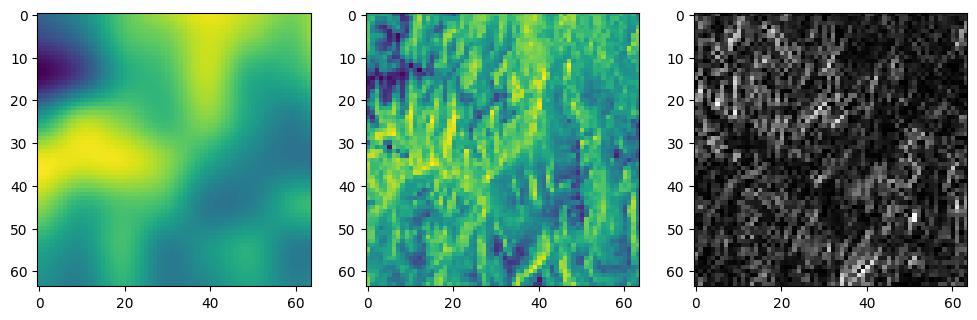

In [20]:
hr, lr = iter(sampler.generate_data()).__next__()
print(hr.shape, lr.shape)

for i in range(batch_size):
    _, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(lr[i, 0, :, :].detach().cpu().squeeze())
    axs[1].imshow(hr[i, 0, :, :].detach().cpu().squeeze())
    axs[2].imshow(hr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")

# Training utils


### Loss initialisation

In [21]:
class SSIMLoss(SSIM):
    @staticmethod
    def check_dim(x):
        try:
            _, c, _, _ = x.shape
        except:
            c, _, _ = x.shape
            x = x.unsqueeze(0)

        if c == 1:
            x = x.repeat(1,3,1,1)
        elif c == 2:
            x = x[:,0,:,:].unsqueeze(1).repeat(1,3,1,1)
        return x

    @staticmethod
    def cast_values(x):
        x = torch.where(x<0, 0.0, x)
        x = torch.where(x>1, 1.0, x)
        return x

    def forward(self, x, y):
        x = self.check_dim(self.cast_values(x))
        y = self.check_dim(self.cast_values(y))
        return 1. - super().forward(x, y)

class ZeroShotLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1   = torch.nn.L1Loss()
        self.ssim = SSIMLoss()
    def forward(self, x, y):
        return self.l1(x, y) + self.ssim(x, y)

### Procedure

In [22]:
# Deprecated -------------------------------------------------------------------
def train(model, img, ground_truth, sampler, sr_factor, num_iter, learning_rate,
          crop_size, reduce_epoch=1000, reduce_sf=0.1):
    """ Train with random sampling image generator
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic",
                         antialias=True).to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)
    cache_train, cache_eval = torch.zeros(num_iter), torch.zeros(num_iter)
    progress_bar = tqdm(range(num_iter), total=num_iter)
    for iteration in progress_bar:

        model.train()
        hr, lr = sampler.generate_data().__next__()
        hr, lr = hr.to(DEVICE), lr.to(DEVICE)
        output = model(lr)
        error  = loss_function(output, hr)
        error.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Eval performance
        model.eval()
        with torch.no_grad():
            inference  = model(img_up)
            error_eval = loss_function(inference, ground_truth)

        # Save logs
        cache_train[iteration] = error.item()
        cache_eval[iteration]  = error_eval.item()
        progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_iter} lr: {learning_rate} Loss «{(error.item()):.10f}» Eval_loss «{(error_eval.item()):.10f}»")

        # Adjust learning rate
        if iteration > 0 and iteration % reduce_epoch == 0:
            learning_rate = learning_rate * reduce_sf
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {}".format(learning_rate) )

    print("Training Done!")
    return {"train":cache_train, "eval":cache_eval}


def train_dl(model, img, ground_truth, dataloader, sr_factor, num_iter, learning_rate,
             crop_size, reduce_epoch=1000, reduce_sf=0.1):
    """ Train with random sampling image generator
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic",
                         antialias=True).to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)
    cache_train, cache_eval = torch.zeros(num_iter), torch.zeros(num_iter)
    progress_bar = tqdm(range(num_iter), total=num_iter)
    for iteration in progress_bar:

        model.train()
        for hr, lr in dataloader:
            hr, lr = hr.to(DEVICE), lr.to(DEVICE)
            output = model(lr)
            error  = loss_function(output, hr)
            error.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Eval performance
        model.eval()
        with torch.no_grad():
            inference  = model(img_up)
            error_eval = loss_function(inference, ground_truth)

        # Save logs
        cache_train[iteration] = error.item()
        cache_eval[iteration] = error_eval.item()
        progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_iter} lr: {learning_rate} Loss «{(error.item()):.10f}» Eval_loss «{(error_eval.item()):.10f}»")

        # Adjust learning rate
        if iteration > 0 and iteration % reduce_epoch == 0:
            learning_rate = learning_rate * reduce_sf
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

    print("Training Done!")
    return {"train":cache_train, "eval":cache_eval}
# Deprecated -------------------------------------------------------------------


def train_prog(model, img, ground_truth, sampler, sr_factor, num_iter, num_items,
               learning_rate, crop_size, batch_size, npairs, trainonly=False,
               reduce_epoch=1000, reduce_sf=0.1):
    """ Progressively enhance intermediate scale factor
    !! Implement: reduce lr at iteration number
    !! Implement: progressively reducing via error linear fit variance
    Args:
        npairs: (list) of pairs to be considered in intermediate training
            e.g. [8, 6, 4, 2, 0]
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size),
        pad_if_needed=True)])

    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic",
        antialias=True).to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)

    sampler_sub_steps = len(npairs)
    tot_iters = num_iter * npairs
    cache_train, cache_eval = [], []

    # Loop over substeps
    for sub_step in npairs:
        print("Now on #{} substep (forward).".format(sub_step))

        # Initialise the dataset
        ids = IntermediateDataset(num_items, sampler.pairs[sub_step],
            full_size=100, transform=transf)
        dataloader = torch.utils.data.DataLoader(ids, batch_size, shuffle=False)
        progress_bar = tqdm(range(num_iter), total=num_iter)

        # Loop over current datapair iterations
        for iteration in progress_bar:

            model.train()
            cum_error, nsample = 0.0, 0
            for hr, lr in dataloader:
                hr, lr = hr.to(DEVICE), lr.to(DEVICE)
                output = model(lr)
                error  = loss_function(output, hr)
                error.backward()
                optimizer.step()
                optimizer.zero_grad()
                cum_error += error.item()
                nsample += lr.shape[0]

            # Save and print logs
            train_error = cum_error/nsample
            cache_train.append(train_error)

            # Eval performance
            if not trainonly:
                model.eval()
                with torch.no_grad():
                    inference = model(img_up)
                    error_eval = loss_function(inference, ground_truth)
                e_error = error_eval.item()
                cache_eval.append(e_error)
                progress_bar.set_postfix_str(
                    "Iteration: {} lr: {} Loss: «{:.10f}» Eval Loss «{:.10f}»".\
                    format((iteration+1)/num_iter, learning_rate, train_error, e_error))
                    #f"Iteration: lr: {learning_rate} Loss «{(train_error):.10f}» Eval_loss «{(error_eval.item()):.10f}»")
            else:
                progress_bar.set_postfix_str(
                    "Iteration: {} lr: {} Loss: «{:.10f}»".\
                    format((iteration+1)/num_iter, learning_rate, train_error))
                    #f"Iteration: lr: {learning_rate} Loss «{(train_error):.10f}» Eval_loss «{(error_eval.item()):.10f}»")

    print("Training Done!")
    return {"train":cache_train, "eval":cache_eval}


def test(model, img, sr_factor):
    """ Perform ZS SR considering a new SR factor:
    Args:
        model: (torch.nn.Module) currently self-supervised trained model
        img: (torch.Tensor)
        sr_factor: (int)
    Return:
        SR inference, original img (bicubic upsampled)
    """

    img_up = img.unsqueeze(0) if len(img.shape) < 4 else img
    img_up = interpolate(img_up, scale_factor=sr_factor, mode="bicubic", antialias=True)\
             .to(DEVICE)

    model.eval()
    with torch.no_grad():
        inference = model(img_up)
    return inference, img_up[:, 0, :, :].unsqueeze(1)


def estimate_performance(srimg, ground_truth):
    """ Return inference evaluation metrics
    """
    return [loss_function(srimg, ground_truth).item(),
            mae(srimg, ground_truth).item(),
            mse(srimg, ground_truth).item(),
            (-psnr(srimg, ground_truth)).item(),
            (1-ssim(srimg, ground_truth)).item(),
            (srimg - ground_truth).mean().item()]

def print_performance(rmet, imet):
    print("\n         | Loss     | MAE      | MSE      | PSNR      | SSIM")
    print("--------------------------------------------------------------------")
    print("Bicubic: | {:.6f} | {:.6f} | {:.6f} | {:.6f} | {:.6f}".\
        format(rmet[0], rmet[1], rmet[2], rmet[3], rmet[4]))
    print("   ZSSR: | {:.6f} | {:.6f} | {:.6f} | {:.6f} | {:.6f}".\
        format(imet[0], imet[1], imet[2], imet[3], imet[4]))

def plot_training_performance(history, reference_loss, ylim=None):
    plt.plot(history["train"], label="train");
    plt.plot(history["eval"],  label="ZSSR eval");
    plt.hlines(rmet[0], 0, len(history["train"]), colors="red", linestyle="dashed", label="reference")
    plt.title("Training performance");
    plt.ylabel("Loss (L1+SSIM)");
    if ylim:
        plt.ylim(ylim)
    plt.legend(); plt.grid(); plt.show()

def plot_results(img_up, srimg, ground_truth, vmin, vmax):
    _, axs = plt.subplots(1, 3, figsize=(15, 10))
    for i,item in enumerate((img_up, srimg, ground_truth)):
        axs[i].imshow(item.cpu().squeeze(), vmin=llim, vmax=ulim)
    plt.show()


loss_function = ZeroShotLoss().to(DEVICE)
mae  = torch.nn.L1Loss().to(DEVICE)
mse  = torch.nn.MSELoss().to(DEVICE)
ssim = SSIMLoss().to(DEVICE)
psnr = PSNR().to(DEVICE)

# No High Frequency guidance training

Now on #8 substep (forward).


100%|██████████| 1/1 [00:02<00:00,  2.26s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0063229837» Eval Loss «0.2756725550»]


Training Done!

         | Loss     | MAE      | MSE      | PSNR      | SSIM
--------------------------------------------------------------------
Bicubic: | 0.105868 | 0.028792 | 0.000967 | 30.145630 | 0.922924
   ZSSR: | 0.275673 | 0.177137 | 0.031551 | 15.009927 | 0.901464


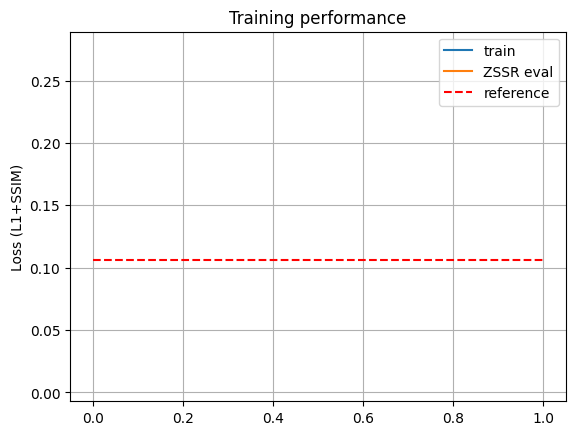

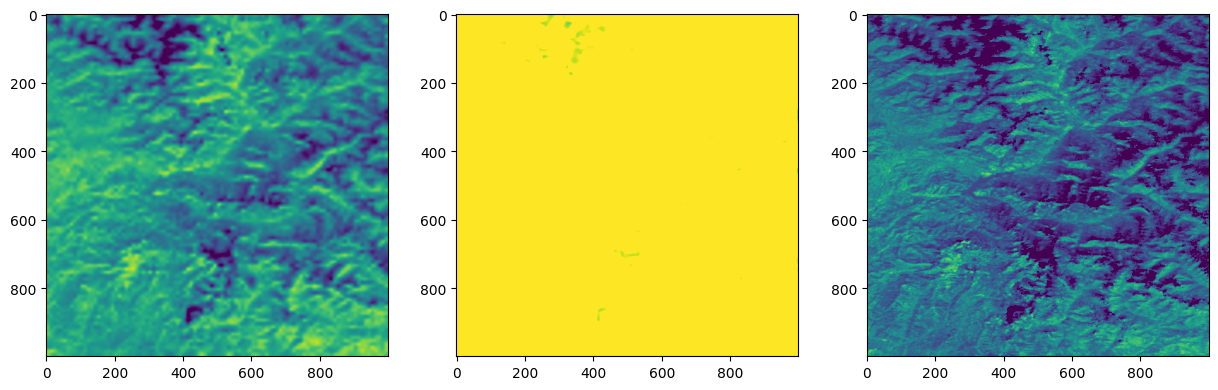

In [23]:
CUDA_LAUNCH_BLOCKING=1
UP_SCALE   = 10
NUM_ITER   = 1
LEARN_RATE = 1e-3
CROP_SIZE  = 64
BATCH_SIZE = 64
DL_ITEMS   = 64

filenameLR = "AG1km.v003.45.006.0010.h5"
filanameHR = "AG100.v003.45.006.0001.h5"
ground_truth = read_h5_temperature(filanameHR).unsqueeze(0).to(DEVICE)
img          = read_h5_temperature(filenameLR).to(DEVICE)
llim, ulim   = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()
channels = 1

# initialise sampler
transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size), pad_if_needed=True)])
sampler = DataSamplerBatch(img, UP_SCALE, CROP_SIZE, BATCH_SIZE, crop_only=True)
ids     = IntermediateDataset(DL_ITEMS, sampler.pairs[0], full_size=100, transform=transf)
dataloader = torch.utils.data.DataLoader(ids, batch_size=BATCH_SIZE, shuffle=False)

# Model initialisation -- ZSSRNet (e2000, lr1e-5, cs64, bs16)
model  = ZSSRNet(input_channels=channels, out_channels=1, kernel_size=3, channels=4, ndepth=4).to(DEVICE)
#model = MRUNet(n_channels=channels, n_outchannels=1, n_resblocks=2).to(DEVICE)

# Perform training
history = train_prog(model, img, ground_truth, sampler,
                sr_factor=UP_SCALE,
                num_iter=NUM_ITER,
                num_items=DL_ITEMS,
                learning_rate=LEARN_RATE,
                crop_size=CROP_SIZE,
                batch_size=BATCH_SIZE,
                npairs=[8],#list(reversed(range(0,9))),
                reduce_epoch=int(NUM_ITER*0.75),
                reduce_sf=0.1)

# Evaluate on upscaled image
srimg, img_up  = test(model, img, sr_factor=UP_SCALE)
# Estimate performance
rmet = estimate_performance(img_up, ground_truth)
imet = estimate_performance(srimg, ground_truth)
# Show results
print_performance(rmet, imet)
plot_training_performance(history, rmet[0])
plot_results(img_up, srimg, ground_truth, llim, ulim)

# High Frequency guided Training

Successful combination
```python
UP_SCALE = 10
NUM_ITER = 50 # 200
LEARN_RATE = 1e-3
CROP_SIZE = 100
BATCH_SIZE = 4
```

Now on #8 substep (forward).


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([64, 2, 64, 64])) that is different to the input size (torch.Size([64, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 1/1 [00:01<00:00,  1.13s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0110328794» Eval Loss «0.0863047540»]


Now on #5 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.34s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0098628029» Eval Loss «0.0869215056»]


Now on #3 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.30s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0091266111» Eval Loss «0.0874623060»]


Training Done!

         | Loss     | MAE      | MSE      | PSNR      | SSIM
--------------------------------------------------------------------
Bicubic: | 0.105868 | 0.028792 | 0.000967 | 30.145630 | 0.922924
   ZSSR: | 0.087462 | 0.010801 | 0.000203 | 36.918564 | 0.923339


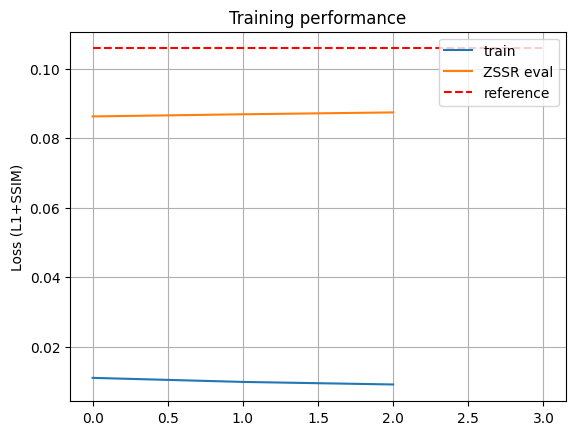

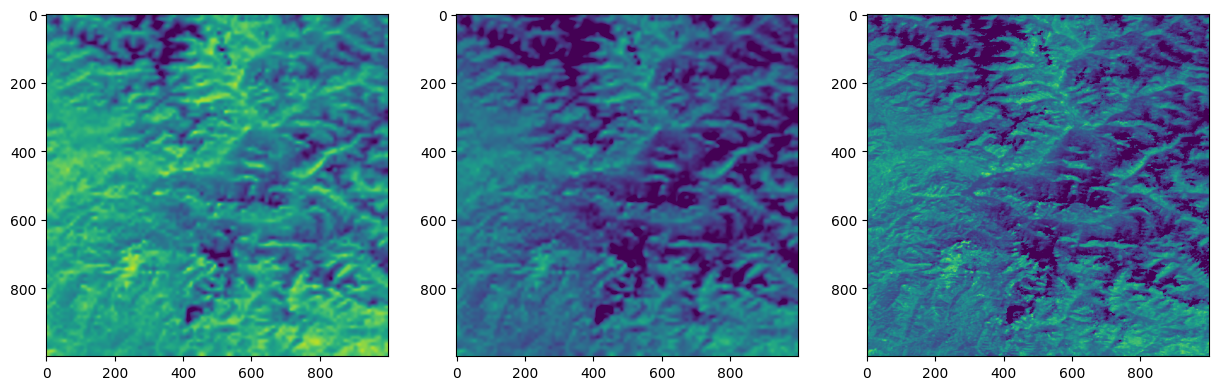

In [25]:
#UP_SCALE = 10 NUM_ITER = 50 # 200 LEARN_RATE = 1e-3 CROP_SIZE = 100 BATCH_SIZE = 4
CUDA_LAUNCH_BLOCKING=1
UP_SCALE   = 10
NUM_ITER   = 1
LEARN_RATE = 1e-3
CROP_SIZE  = 64
BATCH_SIZE = 64
DL_ITEMS   = 64

filenameLR = "AG1km.v003.45.006.0010.h5"
filanameHR = "AG100.v003.45.006.0001.h5"
ground_truth = read_h5_temperature(filanameHR).unsqueeze(0).to(DEVICE)
img          = read_h5_temperature(filenameLR)
llim, ulim   = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()

# Initialise sampler
sampler = DataSamplerBatchHF(img, UP_SCALE, CROP_SIZE, BATCH_SIZE, crop_only=True)

# Model initialisation
model  = ZSSRNet(input_channels=2, out_channels=1, kernel_size=3, channels=4, ndepth=2).to(DEVICE)
#model = MRUNet(n_channels=2, n_outchannels=1, n_resblocks=1).to(DEVICE)

history = train_prog(model, img, ground_truth, sampler,
                sr_factor=UP_SCALE,
                num_iter=NUM_ITER,
                num_items=DL_ITEMS,
                learning_rate=LEARN_RATE,
                crop_size=CROP_SIZE,
                batch_size=BATCH_SIZE,
                npairs=[8,5,3],#list(reversed(range(0,9))),
                reduce_epoch=int(NUM_ITER*0.75),
                reduce_sf=0.1,
                trainonly=False)

# Evaluate on upscaled image
srimg, img_up  = test(model, sampler.img, sr_factor=UP_SCALE)
# Estimate performance
rmet = estimate_performance(img_up, ground_truth)
imet = estimate_performance(srimg, ground_truth)
# Show results
print_performance(rmet, imet)
plot_training_performance(history, rmet[0])
plot_results(img_up, srimg, ground_truth, llim, ulim)

# Zero Shot via High Frequency Guided information


### HFG module implementation
As in Liu et al., 2024 (https://doi.org/10.1016/j.engappai.2024.109336)


In [26]:
class HFCrossAttention(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        """ High Frequency Guided Cross Attention block that operates as skip
        connection step
        Args:
            in_channels: (int) X_{features} channel dimension
            hidden_dim: (int) internal channeld dim
        """
        super(HFCrossAttention, self).__init__()
        self.hidden_dim  = hidden_dim
        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True

        # Convolutional encoder to process Q, K, V
        self.convHF = nn.Conv2d(1, hidden_dim, 3, 1, "same", bias=False)
        self.convK  = nn.Conv2d(in_channels, hidden_dim, 3, 1, "same", bias=False)
        self.convV  = nn.Conv2d(in_channels, hidden_dim, 3, 1, "same", bias=False)
        self.convA  = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding="same", bias=False)
        self.conv1  = nn.Conv2d(hidden_dim, in_channels, 1, bias=False)

    def forward(self, x, orig_hf):
        """ Args:
            x: (torch.Tensor) LR image of dim (b, c, h, w)
            orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, _, h, w = x.shape
        # tokens: with shape (batch, h*w, hdim)
        Q = self.convHF(orig_hf).view(b, h*w, self.hidden_dim)
        K = self.convK(x).view(b, h*w, self.hidden_dim)
        V = self.convV(x).view(b, h*w, self.hidden_dim)

        #scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # inner product of Q and K, a tensor
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K)\
                    .view(b, 1, self.hidden_dim, self.hidden_dim)
        scoremats = self.convA(scoremats)\
                    .view(b, self.hidden_dim, self.hidden_dim)
        attnmats  = torch.nn.functional.softmax(scoremats/torch.sqrt(self.d), dim=-1)
        # To (batch, hdim, h, w)
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V)\
                    .view(b, self.hidden_dim, h, w)
        # 1k conv to (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return x + ctx_vecs


class TransformerBlock(nn.Module):
    """ Single Transformer block (no multhihead implmentation)
    """
    def __init__(self, in_channel, hidden_dim):
        super(TransformerBlock, self).__init__()
        self.cattn = HFCrossAttention(in_channel, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(hidden_dim, 2 * hidden_dim),
            nn.ReLU(), # GELU
            nn.Linear(2 * hidden_dim, hidden_dim),
        )

    def forward(self, x, orig_hf):
        """ Args:
            x: (torch.Tensor) LR image of dim (b, c, h, w)
            orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, c, h, w = x.shape

        x = self.cattn(self.norm1(x), orig_hf) + x
        x = self.ffn(self.norm2(x)) + x
        return x

class HFGModule(nn.Module):
    def __init__(self, in_channel, hidden_dim, nblocks):
        super(HFGModule, self).__init__()
        self.transblocks = nn.ModuleList(
            TransformerBlock(in_channel, hidden_dim) for _ in range(nblocks)
        )

    def forward(self, x, orig_hf):
        for block in self.transblocks:
            x = block(x, orig_hf)
        return x

# Test
in_channel = 1
hidden_dim = 64
ca = HFCrossAttention(in_channel, hidden_dim)
tr = TransformerBlock(in_channel, hidden_dim)
hfgm = HFGModule(in_channel, hidden_dim, nblocks=1)

x       = torch.rand((4, in_channel, 64, 64))
orig_hf = torch.rand((4, 1, 64, 64))

out = ca(x,orig_hf)
out2 = tr(x, orig_hf)
out3 = hfgm(x, orig_hf)

#norm = nn.LayerNorm(hidden_dim)
#print(norm(x).shape)
print("CrossAtt output", out.shape)
print("Tblock output", out2.shape)
print("HFG module output", out3.shape)
print(f"Learnable params: {sum(p.numel() for p in hfgm.parameters() if p.requires_grad)}")

CrossAtt output torch.Size([4, 1, 64, 64])
Tblock output torch.Size([4, 1, 64, 64])
HFG module output torch.Size([4, 1, 64, 64])
Learnable params: 18634


### ResBlock
Testing implementation of ResNet Block

In [27]:
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.ReLU() # GELU
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.ReLU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])
    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x

# Testing
in_channels = 16
x = torch.rand((12, in_channels, 64, 64))
net = ResBlock(nchannels=in_channels, ndepth=4)
print(net(x).shape)
print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")
print(net)

torch.Size([12, 16, 64, 64])
Learnable params: 18688
ResBlock(
  (act): ReLU()
  (res_conv_blocks): ModuleList(
    (0-3): 4 x Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


### HFG network
Complete High Freq guided Network implementation

In [28]:
# from https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.ReLU() # GELU
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.ReLU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])
    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.up(x)


class HFCrossAttention(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        """ High Frequency Guided Cross Attention
        Args:
            in_channels: (int) X_{features} channel dimension
            hidden_dim: (int) internal channeld dim
        """
        super(HFCrossAttention, self).__init__()
        self.hidden_dim = hidden_dim

        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True

        # Convolutional encoder to process Q, K, V
        self.convHF = nn.Conv2d(1, hidden_dim, 3, 1, "same", bias=False)
        self.convK  = nn.Conv2d(in_channels, hidden_dim, 3, 1, "same", bias=False)
        self.convV  = nn.Conv2d(in_channels, hidden_dim, 3, 1, "same", bias=False)
        self.convA  = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding="same", bias=False)
        self.conv1  = nn.Conv2d(hidden_dim, in_channels, 1, bias=False)

    def forward(self, x, orig_hf):
        """ Args:
            x: (torch.Tensor) LR image of dim (b, c, h, w)
            orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, _, h, w = x.shape
        # tokens: with shape (batch, h*w, hdim)
        Q = self.convHF(orig_hf).view(b, h*w, self.hidden_dim)
        K = self.convK(x).view(b, h*w, self.hidden_dim)
        V = self.convV(x).view(b, h*w, self.hidden_dim)

        #scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # inner product of Q and K, a tensor
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K)\
                    .view(b, 1, self.hidden_dim, self.hidden_dim)
        scoremats = self.convA(scoremats)\
                    .view(b, self.hidden_dim, self.hidden_dim)
        attnmats  = torch.nn.functional.softmax(scoremats/torch.sqrt(self.d), dim=-1)
        # To (batch, hdim, h, w)
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V)\
                    .view(b, self.hidden_dim, h, w)
        # 1k conv to (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return x + ctx_vecs



class HFGNet(nn.Module):
    def __init__(self, img_ch=1, output_ch=1, hidden_dim=96, ndepth=1):
        """ Simplified HFGNet implementation
        Args:
        """
        super(HFGNet, self).__init__()
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.ResBlock1 = ResBlock(img_ch, ndepth)
        self.Conv1     = ConvBlock(ch_in=img_ch, ch_out=64)
        self.ResBlock2 = ResBlock(64, ndepth)
        self.Conv2     = ConvBlock(ch_in=64, ch_out=128)
        self.ResBlock3 = ResBlock(128, ndepth)
        self.Conv3     = ConvBlock(ch_in=128, ch_out=256)

        self.Up3 = UpConv(ch_in=256, ch_out=128)
        #self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.hfgAtt3 = HFCrossAttention(in_channels=128, hidden_dim=hidden_dim)

        self.Up_conv3 = ConvBlock(ch_in=256, ch_out=128)

        self.Up2 = UpConv(ch_in=128,ch_out=64)
        #self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.hfgAtt2 = HFCrossAttention(in_channels=64, hidden_dim=hidden_dim)

        self.Up_conv2 = ConvBlock(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        orig    = x[:, 0, :, :].unsqueeze(1).clone()
        orig_hf = x[:, 1, :, :].unsqueeze(1).clone()

        x1 = self.ResBlock1(orig)
        x1 = self.Conv1(x1)

        x2 = self.Maxpool(x1)
        x2 = self.ResBlock2(x2)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.ResBlock3(x3)
        x3 = self.Conv3(x3) # 256 ch

        d3 = self.Up3(x3)

        # Rescale orig_hf to this dim
        orig_hf3 = interpolate(orig_hf, scale_factor=1/2, mode="bilinear", antialias=True)
        x2 = self.hfgAtt3(x2, orig_hf3)
        d3 = torch.cat((x2, d3), dim=1) # 128 + 128 at channels dim

        d3 = self.Up_conv3(d3)
        d2 = self.Up2(d3)
        x1 = self.hfgAtt2(x1, orig_hf)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        return d1 + orig

net = HFGNet(img_ch=1, output_ch=1, hidden_dim=96, ndepth=1)
#net = ResBlock(1, 1)
x = torch.rand((16, 2, 64, 64))
print(net(x).shape)

print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

torch.Size([16, 1, 64, 64])
Learnable params: 2790827


Testing a full HFG network made by HFG blocks.

In [ ]:
class FullHFG(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=96, nblocks=8):
        super(FullHFG, self).__init__()
        self.blocks = nn.ModuleList(
            HFCrossAttention(in_channels, hidden_dim)
            for _ in range(nblocks)
        )
    def forward(self, x):
        x1      = x[:, 0, :, :].unsqueeze(1).clone()
        orig    = x[:, 0, :, :].unsqueeze(1).clone()
        orig_hf = x[:, 1, :, :].unsqueeze(1).clone()

        for block in self.blocks:
            x1 = block(x1, orig_hf)
        return x1 + orig

x = torch.rand((16, 2, 64, 64))
net = FullHFG()
print(net(x).shape)
print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

torch.Size([16, 1, 64, 64])
Learnable params: 21584


### Training

Successful HFGNet hyperparameter setting
```python
UP_SCALE   = 10
NUM_ITER   = 5
LEARN_RATE = 1e-3
CROP_SIZE  = 64
BATCH_SIZE = 64
DL_ITEMS   = 256
```

Now on #8 substep (forward).


100%|██████████| 5/5 [00:06<00:00,  1.23s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0083254415» Eval Loss «0.0637028441»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.11s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079907647» Eval Loss «0.0606598184»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.12s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0080499721» Eval Loss «0.0612281524»]


Training Done!

         | Loss     | MAE      | MSE      | PSNR      | SSIM
--------------------------------------------------------------------
Bicubic: | 0.064639 | 0.041230 | 0.001733 | 27.611380 | 0.976591
   ZSSR: | 0.061228 | 0.035864 | 0.001402 | 28.532736 | 0.974635


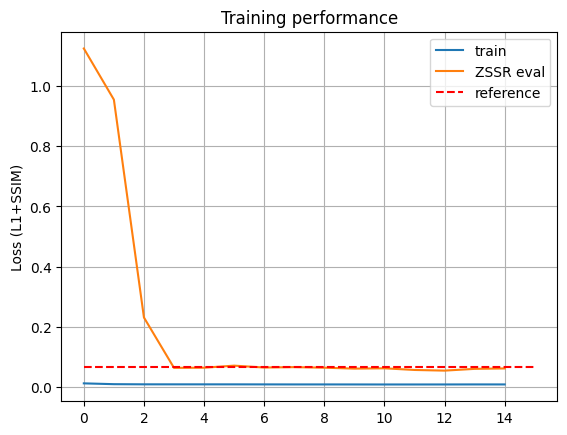

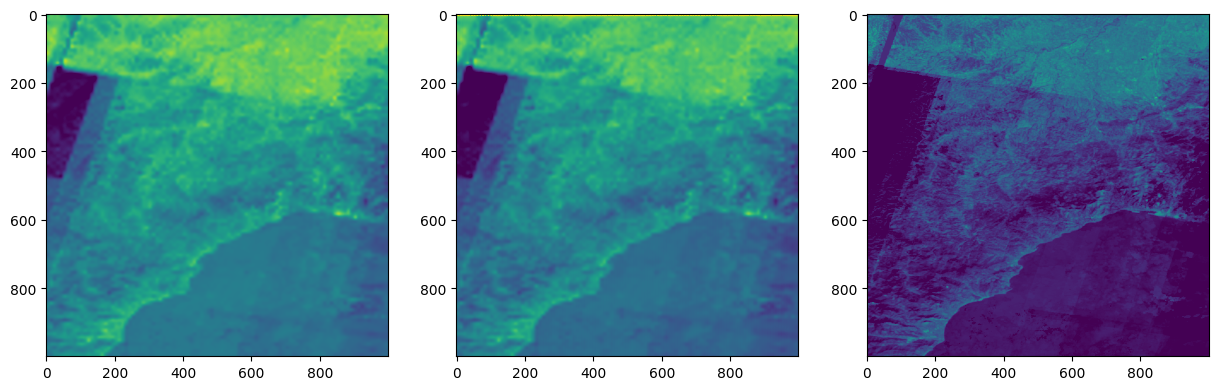

In [30]:
#UP_SCALE = 10 NUM_ITER = 50 # 200 LEARN_RATE = 1e-3 CROP_SIZE = 100 BATCH_SIZE = 4
CUDA_LAUNCH_BLOCKING=1
UP_SCALE   = 10
NUM_ITER   = 5
LEARN_RATE = 1e-3
CROP_SIZE  = 64
BATCH_SIZE = 64
DL_ITEMS   = 256

filenameLR = "AG1km.v003.45.008.0010.h5"
filanameHR = "AG100.v003.45.008.0001.h5"
ground_truth = read_h5_temperature(filanameHR).unsqueeze(0).to(DEVICE)
img          = read_h5_temperature(filenameLR)
llim, ulim   = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()

# Initialise sampler
sampler = DataSamplerBatchHF(img, UP_SCALE, CROP_SIZE, BATCH_SIZE, crop_only=True)

# Model initialisation
#model = HFGNet(input_channels=1, nchannels=256, nblocks=1).to(DEVICE)
model = HFGNet(img_ch=1, output_ch=1, hidden_dim=16, ndepth=1).to(DEVICE)
#model = FullHFG(in_channels=1, hidden_dim=32, nblocks=4).to(DEVICE)

history = train_prog(model, img, ground_truth, sampler,
                sr_factor=UP_SCALE,
                num_iter=NUM_ITER,
                num_items=DL_ITEMS,
                learning_rate=LEARN_RATE,
                crop_size=CROP_SIZE,
                batch_size=BATCH_SIZE,
                npairs=[8,7,6],
                )

# Evaluate on upscaled image
srimg, img_up  = test(model, sampler.img, sr_factor=UP_SCALE)
# Estimate performance
rmet = estimate_performance(img_up, ground_truth)
imet = estimate_performance(srimg, ground_truth)
# Show results
print_performance(rmet, imet)
plot_training_performance(history, rmet[0], ylim=None)
plot_results(img_up, srimg, ground_truth, llim, ulim)

---

# Validation

### Validation functions

In [32]:
UP_SCALE = 10
LEARN_RATE = 1e-3

def get_tiles_list():
    lrlist = sorted([item for item in os.listdir() if item.startswith("AG1km")])
    hrlist = sorted([item for item in os.listdir() if item.startswith("AG100")])
    return [(lrlist[i], hrlist[i]) for i in range(len(lrlist)) ]

def build_model(name):
    if name == "zssrnet":
        model = ZSSRNet(input_channels=1, out_channels=1, kernel_size=3,
                        channels=64, ndepth=6)
    elif name == "zssrnet_hf":
        model = ZSSRNet(input_channels=2, out_channels=1, kernel_size=3,
                        channels=64, ndepth=6)
    elif name == "mrunet":
        model = MRUNet(n_channels=1, n_outchannels=1, n_resblocks=1)
    elif name == "mrunet_hf":
        model = MRUNet(n_channels=2, n_outchannels=1, n_resblocks=1)
    elif name == "hfgnet_s":
        model = HFGNet(hidden_dim=16)
    elif name == "hfgnet_m":
        model = HFGNet(hidden_dim=96)
    return model.to(DEVICE)

def build_sampler(modelname, up_scale, crop_size, batch_size):
    return DataSamplerBatch(img, up_scale, crop_size, batch_size)\
         if modelname in ("zssrnet", "mrunet")\
         else DataSamplerBatchHF(img, up_scale, crop_size, batch_size)

def eval_single_combination(storagefname, filenameLR, filenameHR, hparams,
                            ntrials=10):
    print(filenameLR)
    print(filenameHR)
    try:
        f = open(storagefname,)
        storage = json.load(f)
    except:
        storage = dict()

    if filenameLR not in storage:
        storage[filenameLR] = dict()
        storage[filenameLR]["inference"] = list()
        storage[filenameLR]["reference"] = dict()

    # Collect hparams
    modelname, crop_size, niterations, nitems, npairs = hparams

    # Correct batch size, eventually
    batch_size = 4 if nitems < 64 else 64

    # Read data
    img = read_h5_temperature(filenameLR).to(DEVICE)
    ground_truth  = read_h5_temperature(filenameHR).to(DEVICE)

    # Build model
    model = build_model(modelname)

    # Build sampler
    sampler = build_sampler(modelname, UP_SCALE, crop_size, batch_size)

    icache = []
    for ntrial in range(ntrials):

        # Evaluate
        history = train_prog(model, img, ground_truth, sampler, UP_SCALE,
            niterations, nitems, LEARN_RATE, crop_size, batch_size, npairs,
            trainonly=True)
        srimg, img_up = test(model, sampler.img, sr_factor=UP_SCALE)
        imet = estimate_performance(srimg, ground_truth)
        icache.append(imet)

    rmet = estimate_performance(img_up, ground_truth)
    print(rmet)

    inference = {
        "modelname":modelname,
        "crop_size":crop_size,
        "niterations":niterations,
        "nitems":nitems,
        "npairs":str(npairs),
        "performance":{
            "loss":[item[0] for item in icache],
            "mae": [item[1] for item in icache],
            "mse": [item[2] for item in icache],
            "psnr":[item[3] for item in icache],
            "ssim":[item[4] for item in icache],
            "bias":[item[5] for item in icache]},
    }
    reference = {"loss":rmet[0],
                 "mae": rmet[1],
                 "mse": rmet[2],
                 "psnr":rmet[3],
                 "ssim":rmet[4],
                 "bias":rmet[5]
    }
    storage[filenameLR]["inference"].append(inference)
    storage[filenameLR]["reference"] = reference

    # update storage.json
    with open(storagefname, "w", encoding="utf-8") as f:
        json.dump(storage, f, ensure_ascii=False, indent=4)


def eval_all_combinations(combinations, storagefname, filenameLR, filenameHR, ntrials=10):
    for hparams in combinations:
        print(hparams)
        eval_single_combination(storagefname, filenameLR, filenameHR, hparams, ntrials)

def eval_all_tiles(tilelist, combinations, storagefname, ntrials=10):
    for filenameLR, filenameHR in tilelist:
        eval_all_combinations(combinations, storagefname, filenameLR, filenameHR, ntrials)

### Perform validation
Over a single tile

In [34]:
OUT_FILE = "test.json"
tilelist = get_tiles_list()

# Define hyperams space
models      = ("zssrnet", "zssrnet_hf",)# "mrunet", "mrunet_hf", "hfgnet_s")
crop_sizes  = (64,)
niterations = (1,)# 5)
nitems      = (64,)# 256, 512)
npairs      = ([8],)# [8, 6, 4, 2])

combinations = list(
    itertools.product(models, crop_sizes, niterations, nitems, npairs)
)

eval_all_tiles(tilelist, combinations, storagefname=OUT_FILE, ntrials=2)
#eval_single_combination("storage.json", filenameLR, filenameHR, combinations[0],
#                        ntrials=10)

('zssrnet', 64, 1, 64, [8])
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


100%|██████████| 1/1 [00:10<00:00, 10.98s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0040475195»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:09<00:00,  9.94s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0039666560»]


Training Done!
[0.10586809366941452, 0.028791779652237892, 0.000967023428529501, 30.1456298828125, 0.9229236841201782, 0.028431210666894913]
('zssrnet_hf', 64, 1, 64, [8])
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([64, 2, 64, 64])) that is different to the input size (torch.Size([64, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 1/1 [00:09<00:00,  9.54s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0109772077»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:10<00:00, 10.78s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0109324846»]


Training Done!
[0.10586809366941452, 0.028791779652237892, 0.000967023428529501, 30.1456298828125, 0.9229236841201782, 0.028431210666894913]


In [50]:
f = open("storage.json",)
data = json.load(f)
data.keys()

dict_keys(['AG1km.v003.45.006.0010.h5', 'AG1km.v003.45.007.0010.h5', 'AG1km.v003.45.008.0010.h5'])

### Collect best hparams

In [44]:
import json
import pandas as pd
import numpy as np

def read_storage(filename):
	f = open(filename,)
	return json.load(f)

def storage_into_table(data):
	saveinf, saveref = [], []
	for tile in data.keys():
		inference = data[tile]["inference"]
		reference = data[tile]["reference"]
		ref_tmp = {k: v for k, v in reference.items()}
		saveref.append(pd.DataFrame(ref_tmp, index=[tile])\
					   .reset_index()\
					   .rename(columns={"index":"tile"}))
		for record in inference:
			tmp = {"tile":tile}
			for k, v in record.items():
				if k != "performance":
					tmp[k] = v
				else:
					for metric, vector in record[k].items():
						tmp[metric] = [vector]
			saveinf.append(pd.DataFrame(tmp))
	return pd.concat(saveinf), pd.concat(saveref)

def get_avg(data, metricsnames):
	for metric in metricsnames:
		data[f"avg_{metric}"] = data[metric].apply(lambda x: pd.Series(x).mean())
		data[f"std_{metric}"] = data[metric].apply(lambda x: pd.Series(x).std())
	return data

def best_combination(data, modelname, metric="avg_loss"):
	""" Return best hyperparams combination from validation data
	Args:
		data: (pd.DataFrame) validation dataframe
		modelname: (str) modelname
		metric: (str) according to which val metric combination has to be gathered
		ascending: (bool) True if metric == 'loss', False if metric in ('PSNR', 'SSIM')
	"""
	ascending = True if metric in ("avg_loss", "avg_mae", "avg_mse") else False
	combination = (data[data["modelname"] == modelname]\
		.sort_values(by = metric, ascending=ascending)\
		.iloc[0][["modelname", "crop_size", "niterations", "nitems", "npairs"]]\
		.tolist())
	# Correct datatype to be json serializable
	for i, _ in enumerate(combination):
		try: combination[i] = int(combination[i])
		except: pass
	# from str to list
	combination[-1] = [
		   int(item) for item in combination[-1].replace("[","").replace("]","").split(",")]
	return combination


filename  = "storage_validation.json"
metrics   = ["loss","mae","mse","psnr","ssim","bias"]
modelname = "zssrnet_hf"
dfvalidation, _ = storage_into_table(read_storage(filename))
dfvalidation    = get_avg(dfvalidation, metrics)
bestcombination = best_combination(dfvalidation, modelname, metric="avg_loss")
print([type(item) for item in bestcombination])

[<class 'str'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'list'>]


### Test

In [ ]:
# merge 2 jsons

In [56]:
# Define tile
storagefname = "storage.json"
modelnames = ("zssrnet", "zssrnet_hf", "mrunet", "mrunet_hf", "hfgnet_s")
ntrials = 10

# Collect tiles list
tilelist = get_tiles_list()

# Collect best hparams combination for each SR architecture
allbestcombinations = [
    best_combination(dfvalidation, modelname, metric="avg_loss")\
    for modelname in modelnames ]

print(allbestcombinations)
print(tilelist)

eval_all_tiles(tilelist, allbestcombinations, storagefname, ntrials)

[['zssrnet', 64, 5, 64, [8, 7]], ['zssrnet_hf', 64, 5, 64, [8, 7]], ['mrunet', 64, 1, 256, [8, 6, 4, 2]], ['mrunet_hf', 64, 5, 256, [8, 6, 4, 2]], ['hfgnet_s', 64, 5, 64, [8, 6, 4, 2]]]
[('AG1km.v003.45.006.0010.h5', 'AG100.v003.45.006.0001.h5'), ('AG1km.v003.45.007.0010.h5', 'AG100.v003.45.007.0001.h5'), ('AG1km.v003.45.008.0010.h5', 'AG100.v003.45.008.0001.h5')]
['zssrnet', 64, 5, 64, [8, 7]]
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00,  9.65it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006026387»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004617346»]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1, 1000, 1000])) that is different to the input size (torch.Size([1, 1, 1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1000, 1000])) that is different to the input size (torch.Size([1, 1, 1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005805845»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004771901»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006022306»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004587118»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005759229»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004652701»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005962465»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004564909»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005745380»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004603207»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005864446»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004562805»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005708614»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.58it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004528932»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005662288»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004587912»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.24it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005753786»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.23it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004605607»]


Training Done!
['zssrnet_hf', 64, 5, 64, [8, 7]]
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([64, 2, 64, 64])) that is different to the input size (torch.Size([64, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 5/5 [00:00<00:00, 10.25it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080126040»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.21it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078461822»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.16it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079540163»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.40it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078476127»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079623554»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078266943»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079599321»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078267977»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.45it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079266131»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078186756»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079213958»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078347949»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.45it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079396488»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078302864»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.41it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079465043»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078336056»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079496922»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.39it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078165326»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.41it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079470193»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.47it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078326194»]


Training Done!
['mrunet', 64, 1, 256, [8, 6, 4, 2]]
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.08s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0122864475»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0050490277»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0036006983»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0031918319»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0042788350»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0021979224»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0014439039»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009667876»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0018083228»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010869976»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008431704»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006086892»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0013100760»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009669584»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006786754»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004759562»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010452938»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010306302»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007567021»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004854192»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009920282»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007284973»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005812043»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004256972»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009697153»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007483530»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005878370»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004566641»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008083207»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006580551»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004985433»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0003749809»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008125361»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006140082»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005306699»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004397561»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008092379»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005902022»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004903802»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004076197»]


Training Done!
['mrunet_hf', 64, 5, 256, [8, 6, 4, 2]]
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0086045950»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079307053»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.00s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077297773»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076476516»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0080523684»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077278609»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077307761»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076037773»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079141383»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076574294»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075725971»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075422209»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078050955»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075972137»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075297239»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074905021»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076825218»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075225557»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074881313»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074728167»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076409993»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074941735»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074681789»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074658849»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076224550»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075175387»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074943837»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074649557»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076014409»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074793907»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074641882»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074647996»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075483916»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074683557»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074613700»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074621011»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075603921»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074703727»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074527230»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074506572»]


Training Done!
['hfgnet_s', 64, 5, 64, [8, 6, 4, 2]]
AG1km.v003.45.006.0010.h5
AG100.v003.45.006.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0098989811»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0091873817»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0088659609»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0082292948»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0094796680»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0082461163»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081882067»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081151202»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0086634969»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080948016»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079770014»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.58it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079951817»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0083756298»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079410803»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079200268»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077558472»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0084386673»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079886885»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078460770»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077277953»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080485987»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078388173»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077856733»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076878071»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080364589»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078756921»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077949408»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077040237»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079746917»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078082671»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077917222»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077004130»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080159074»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078764902»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077816267»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076898076»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079971673»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078336354»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077639287»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076813912»]


Training Done!
['zssrnet', 64, 5, 64, [8, 7]]
AG1km.v003.45.007.0010.h5
AG100.v003.45.007.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006554611»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.04it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004940465»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.15it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005987018»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.16it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004611528»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005813233»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.47it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004631660»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005862737»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004520533»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.40it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005862862»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004668279»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.34it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005843168»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004634126»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005967738»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004502207»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005701091»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.46it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004675631»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005927593»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004697643»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.48it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005867069»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004615656»]


Training Done!
['zssrnet_hf', 64, 5, 64, [8, 7]]
AG1km.v003.45.007.0010.h5
AG100.v003.45.007.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.31it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079509337»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.26it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078457408»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.33it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079649836»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.32it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078290105»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.12it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079409424»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.20it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078403316»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.17it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079605067»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078320485»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079457741»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.35it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078264559»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079363184»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078196051»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.37it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079360418»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078341626»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079643410»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078191189»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.37it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079393629»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.26it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078086248»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079085566»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078261234»]


Training Done!
['mrunet', 64, 1, 256, [8, 6, 4, 2]]
AG1km.v003.45.007.0010.h5
AG100.v003.45.007.0001.h5
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0128088871»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0057873279»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0037568122»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0028046182»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0043511805»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0030701515»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0020411779»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0013790456»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0019279408»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0014885406»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010597275»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008665116»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0015686308»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010848553»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009794085»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007167727»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011157148»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007975650»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006715842»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005228828»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011756180»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008658906»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006904711»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005769551»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011427348»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008737976»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006458889»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005006547»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009536992»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008165437»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006075718»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005091042»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010037333»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007188577»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005295955»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0003941148»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011929489»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007087590»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005867678»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004165451»]


Training Done!
['mrunet_hf', 64, 5, 256, [8, 6, 4, 2]]
AG1km.v003.45.007.0010.h5
AG100.v003.45.007.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0093046855»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0081466886»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079225812»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077282271»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0082848496»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078240320»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077331552»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076276519»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079894490»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077166508»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076527050»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075973310»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079478938»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076955493»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076283249»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075909107»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078963432»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076738752»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076138079»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075732833»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078471561»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076171503»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075505278»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075210355»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077076687»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075482136»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075093169»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074783147»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076602314»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075123883»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074723221»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074674024»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076550028»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074886555»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074680924»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074640833»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075877962»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074825817»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074671039»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074578380»]


Training Done!
['hfgnet_s', 64, 5, 64, [8, 6, 4, 2]]
AG1km.v003.45.007.0010.h5
AG100.v003.45.007.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0106251081»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0096866088»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0086377040»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0082151080»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0090445718»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0083960257»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080668405»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081284642»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0084797945»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079348581»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.47it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078528039»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077954717»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0082259737»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.58it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079576317»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078326911»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.58it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076921922»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081683975»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079433676»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078163259»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.58it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077245184»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.49it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081412252»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078830682»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078227445»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077227545»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081662908»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079510622»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078033870»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077572344»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081157228»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079132682»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077533890»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077038789»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080106696»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078569995»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077828076»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076851305»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079509439»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078124637»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077513857»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076606753»]


Training Done!
['zssrnet', 64, 5, 64, [8, 7]]
AG1km.v003.45.008.0010.h5
AG100.v003.45.008.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.30it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006507616»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004567638»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.12it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006401457»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004666732»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.31it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005919702»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.18it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004613991»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0006084536»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.45it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004618804»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005993730»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.41it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004558626»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005832912»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.29it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004617678»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005864961»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.33it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004594829»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005930453»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.39it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004575753»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005810013»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.44it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004523833»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.41it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0005759433»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0004633890»]


Training Done!
['zssrnet_hf', 64, 5, 64, [8, 7]]
AG1km.v003.45.008.0010.h5
AG100.v003.45.008.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079436237»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078410953»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.39it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079365997»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.34it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078085782»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.28it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079402411»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.19it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078544328»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.43it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079343822»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.33it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078269159»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.23it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079370523»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.27it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078295525»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079423478»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078292340»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.23it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079356665»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.37it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078369211»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.36it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079514896»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.42it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078256652»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.31it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079463683»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.25it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078231264»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.40it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079457024»]


Now on #7 substep (forward).


100%|██████████| 5/5 [00:00<00:00, 10.38it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078403419»]


Training Done!
['mrunet', 64, 1, 256, [8, 6, 4, 2]]
AG1km.v003.45.008.0010.h5
AG100.v003.45.008.0001.h5
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0127593615»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0047300764»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0030215859»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0022916049»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0040231436»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0015227811»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009555504»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006936351»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0015505076»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0010416539»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007977912»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005897915»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011997019»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009220446»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006893982»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005517854»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009338503»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008412169»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006564204»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004900228»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0011015809»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008377461»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006566951»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005194087»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009719874»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007940627»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005576731»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004354578»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0009037155»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006525188»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005357231»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0004181409»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.01s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0007980839»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006209483»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005119814»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0003793791»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0008199228»]


Now on #6 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0006245699»]


Now on #4 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0005048713»]


Now on #2 substep (forward).


100%|██████████| 1/1 [00:01<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0003853312»]


Training Done!
['mrunet_hf', 64, 5, 256, [8, 6, 4, 2]]
AG1km.v003.45.008.0010.h5
AG100.v003.45.008.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0098506380»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0086571709»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077897027»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076949497»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0081469540»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078135082»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076963421»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076305211»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0079004706»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077080403»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076448948»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075943894»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078525960»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076755404»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076069261»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075552177»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0078121718»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076431942»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075932344»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075537089»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077598307»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075992204»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075541682»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075216930»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0077255634»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075764706»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075294791»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074954648»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076622096»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075285628»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074919303»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074757049»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0076011904»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074913813»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074744115»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074720827»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0075871361»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074810232»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.03s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074664713»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:05<00:00,  1.02s/it, Iteration: 1.0 lr: 0.001 Loss: «0.0074580400»]


Training Done!
['hfgnet_s', 64, 5, 64, [8, 6, 4, 2]]
AG1km.v003.45.008.0010.h5
AG100.v003.45.008.0001.h5
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0132083986»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0097901132»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0084947143»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080934344»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0087778680»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080157854»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078559779»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077737365»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0085695786»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081303837»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079501430»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078412602»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.51it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0082952734»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079667643»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078283399»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077262698»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0081978478»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078624561»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078256559»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076957098»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080250930»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.57it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078747608»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077788346»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.50it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076818201»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080142776»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078708753»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077807056»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077021979»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0080127018»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078027938»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077405414»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076561356»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.52it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079628415»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078399824»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077734594»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.53it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076789018»]


Training Done!
Now on #8 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.55it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0079767266»]


Now on #6 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.54it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0078002885»]


Now on #4 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0077267587»]


Now on #2 substep (forward).


100%|██████████| 5/5 [00:01<00:00,  4.56it/s, Iteration: 1.0 lr: 0.001 Loss: «0.0076758023»]


Training Done!
